# MODELOS LIBRO EMPIRICAL MARKET MICROSTRUCTURE

A PIN value of 0 indicates that all trading volume is due to uninformed traders, while a PIN value of 1 indicates that all trading volume is due to informed traders. Therefore, a PIN value between 0 and 1 indicates that some of the trading volume is due to informed traders, and the higher the PIN value, the greater the proportion of trading volume that is due to informed traders.

In this case, the estimated PIN value of 0.16666666666666666 suggests that approximately 16.67% of the trading volume is due to informed traders, while the remaining 83.33% is due to uninformed traders.

In [ ]:
import numpy as np
import yfinance as yf
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import poisson

# Download data
symbol = 'AAPL'
start_date = '2020-01-01'
end_date = '2020-12-31'

data = yf.download(symbol, start=start_date, end=end_date)
data['Order Flow'] = data['Volume'].diff()

# Parameters
alpha = 0.4
mu = 10
epsilon = 10
delta = 0.5

# Poisson probability function
def poisson_probability(n, lambda_):
    return poisson.pmf(n, lambda_)

# Joint distribution function
def pr_b_s(alpha, mu, epsilon, delta, b, s):
    term1 = (1 - alpha) * poisson_probability(b, epsilon) * poisson_probability(s, epsilon)
    term2 = alpha * (delta * poisson_probability(b, epsilon) * poisson_probability(s, mu + epsilon)
                     + (1 - delta) * poisson_probability(b, mu + epsilon) * poisson_probability(s, epsilon))
    return term1 + term2

# Log-likelihood function
def log_likelihood(params, data):
    alpha, mu, epsilon, delta = params
    log_likelihood_sum = 0
    for b, s in zip(data['Order Flow'], data['Order Flow'].shift(-1)):
        log_likelihood_sum += np.log(pr_b_s(alpha, mu, epsilon, delta, b, s))
    return -log_likelihood_sum

# Estimation by maximum likelihood
initial_params = [alpha, mu, epsilon, delta]
result = minimize(log_likelihood, initial_params, args=(data,))
alpha_hat, mu_hat, epsilon_hat, delta_hat = result.x

# Calculate PIN
PIN = alpha_hat * mu_hat / (alpha_hat * mu_hat + 2 * epsilon_hat)

print(f"Estimated parameters: alpha = {alpha_hat}, mu = {mu_hat}, epsilon = {epsilon_hat}, delta = {delta_hat}")
print(f"Estimated PIN: {PIN}")

The Kyle model is a way to understand how a single informed trader makes decisions when trading in the stock market. Unlike the sequential trade model where many informed traders can only trade once, the Kyle model allows for the informed trader to trade multiple times and make strategic decisions based on the price of the stock. The informed trader also considers how much she should trade at a time, in order to avoid affecting the stock price too much. This strategy of breaking up large orders into smaller ones over time is common among traders today. In the Kyle model, there is no bid and ask price, and all trades are made at a fair price.


In the Kyle model, the informed traders aim to maximize their profits by trading on their private information, while the uninformed traders use public information to make trading decisions. The informed traders' actions affect the asset price, and they are willing to pay a cost to trade on their private information. This cost is modeled as a function of the volatility of the asset price and the size of the informed trader's order.

The Kyle model predicts that the price impact of an informed trader's order increases with the size of the order and the volatility of the asset price. The model also predicts that the informed traders will choose to trade more aggressively when the cost of trading is low, such as when the volatility of the asset price is low.

Overall, the Kyle model provides insights into the behavior of informed and uninformed traders in financial markets and how their actions affect the price formation process. It has been widely used to analyze market microstructure issues, including liquidity, price discovery, and market efficiency.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Fetch stock data
symbol = 'AAPL'
start_date = '2022-01-01'
end_date = '2023-04-11'
stock_data = yf.download(symbol, start=start_date, end=end_date)

# Calculate daily returns
stock_data['Returns'] = stock_data['Close'].pct_change()

# Calculate daily volume changes
stock_data['Volume_Change'] = stock_data['Volume'].pct_change()

# Drop missing values
stock_data.dropna(inplace=True)

# Prepare training data for linear regression
X = stock_data['Volume_Change'].values.reshape(-1, 1)
y = stock_data['Returns'].values

# Fit linear regression model
lr = LinearRegression()
lr.fit(X, y)

# Function to implement Kyle's model
def kyle_trade_strategy(stock_data, lr, initial_cash, initial_shares, trading_days):
    cash = initial_cash
    shares = initial_shares
    portfolio_value = []

    for i in range(trading_days):
        # Get stock data for today
        today_data = stock_data.iloc[i]

        # Get the predicted return based on volume change
        predicted_return = lr.predict(np.array(today_data['Volume_Change']).reshape(-1, 1))[0]

        # Calculate optimal trade size
        trade_size = predicted_return / (2 * lr.coef_[0])

        # Trade execution
        if trade_size > 0:
            # Buy shares
            shares_to_buy = int(cash * trade_size / today_data['Close'])
            cost = shares_to_buy * today_data['Close']
            cash -= cost
            shares += shares_to_buy
        elif trade_size < 0:
            # Sell shares
            shares_to_sell = int(shares * abs(trade_size))
            revenue = shares_to_sell * today_data['Close']
            cash += revenue
            shares -= shares_to_sell

        # Calculate portfolio value and store it
        portfolio_value.append(cash + shares * today_data['Close'])

    return portfolio_value

# Set initial conditions and execute Kyle's trading strategy
initial_cash = 10000
initial_shares = 0
trading_days = len(stock_data)
portfolio_value = kyle_trade_strategy(stock_data, lr, initial_cash, initial_shares, trading_days)

# Print portfolio value over time
print("Portfolio value over time:", portfolio_value)

[*********************100%***********************]  1 of 1 completed
Portfolio value over time: [10000.0, 8288.760437011719, 13080.477432250977, 14691.380081176758, 13676.923416137695, 832636.280456543, 167938.58825683594, -26756727.13043213, -66856647.06964111, -869020325.8556519, 4090892180.769287, -9286526481.72754, 80395229468.53906, -112275664057.125, 2419299164209.5, 1752105756271.0, 20637548886572.0, 2496583076690432.0, -2718941424906624.0, -3754942370807808.0, -4.391356906012672e+16, -5.6274706324373504e+17, -5.800398418817843e+16, -3.974535576494801e+18, -9.68041660491078e+19, 1.2928002349970384e+20, 3.637107712743134e+21, -1.3279117197967746e+22, -1.982450534636181e+22, 5.529216578656501e+23, 7.352539465692571e+23, -1.456516614052562e+25, 2.275660452736467e+25, -3.710489770277197e+26, 2.7875881627130474e+27, 1.3913861399167316e+28, -3.539274273470345e+28, -2.3956630847013812e+27, 1.283409398080496e+30, 1.3605896736111018e+31, 2.0015542176295664e+31, -3.05855579849683e+32, 2.0

This passage describes a model of how an informed trader and a market maker interact in a market where there is an uncertain security value and exogenous noise from liquidity traders. The market maker observes the net order flow and sets a price that is increasing in the order flow to protect themselves from being on the wrong side of the trade. The informed trader wants to trade aggressively, but the market maker's pricing rule acts as a brake on their desires. The model derives the optimal strategies for both the informed trader and the market maker under certain assumptions, and uses the bivariate normal projection to compute the conditional expectation of the security value given the order flow. The results show that the informed trader trades less as liquidity drops, and the market maker's pricing rule depends on the volatility of the noise traders and the informed trader's signal.

In [2]:
import yfinance as yf
import numpy as np

# Download historical data for a stock
ticker = "AAPL"
stock_info = yf.Ticker(ticker)
hist_data = stock_info.history(period="5y")

# Calculate stock parameters
p0 = hist_data['Close'][-1]
sigma0 = hist_data['Close'].rolling(window=30).std().iloc[-1]
sigma_u2 = hist_data['Volume'].rolling(window=30).std().iloc[-1]

# Model parameters
alpha = (sigma_u2 * p0) / (sigma0**2)
mu = p0
lambda_ = (2 * sigma_u2) / (sigma0**2)
beta = (sigma0**2) / (sigma_u2 + (sigma0**2))

# Display results
print(f"Stock: {ticker}")
print(f"p0: {p0:.2f}")
print(f"sigma0: {sigma0:.2f}")
print(f"sigma_u2: {sigma_u2:.2f}")
print(f"Model parameters:")
print(f"alpha: {alpha:.4f}")
print(f"mu: {mu:.4f}")
print(f"lambda: {lambda_:.4f}")
print(f"beta: {beta:.4f}")

Stock: AAPL
p0: 173.75
sigma0: 3.74
sigma_u2: 14133056.31
Model parameters:
alpha: 175467546.3978
mu: 173.7500
lambda: 2019770.3182
beta: 0.0000


This chapter is about using data to study how information affects stock prices. The authors start by discussing a model called the Roll model, which is used to understand how trades by informed investors affect the price of a stock. They then develop a more general version of the Roll model that allows for the price of a stock to be influenced by whether a trade is a buy or a sell. They focus on models that only look at changes in stock prices, rather than both prices and the direction of trades. This is because it is often difficult to get data on both prices and trades in many markets.

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
from statsmodels import api as sm

def generalized_roll_model(ticker, start_date, end_date):
    # Download stock data
    stock_data = yf.download(ticker, start=start_date, end=end_date)

    # Calculate daily returns
    stock_data['Returns'] = stock_data['Adj Close'].pct_change()

    # Calculate trade direction indicator variable (1 for positive return, -1 for negative return)
    stock_data['Trade Direction'] = np.sign(stock_data['Returns'])

    # Create lagged trade direction column
    stock_data['Lagged Trade Direction'] = stock_data['Trade Direction'].shift(1)

    # Drop rows with missing values
    stock_data.dropna(inplace=True)

    # Create dependent and independent variables
    y = stock_data['Returns']
    X = stock_data[['Trade Direction', 'Lagged Trade Direction']]

    # Add a constant to the independent variables
    X = sm.add_constant(X)

    # Fit the OLS model
    model = sm.OLS(y, X).fit()

    # Print the model summary
    print(model.summary())

# Example usage
ticker = 'AAPL'
start_date = '2021-01-01'
end_date = '2021-12-31'
generalized_roll_model(ticker, start_date, end_date)



[*********************100%***********************]  1 of 1 completed
                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     175.8
Date:                Thu, 11 May 2023   Prob (F-statistic):           3.89e-48
Time:                        15:42:38   Log-Likelihood:                 790.42
No. Observations:                 249   AIC:                            -1575.
Df Residuals:                     246   BIC:                            -1564.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In simple terms, this section discusses how to make forecasts and predict the effects of a hypothetical event in a market, such as making a buy order. The forecast is computed by stepping the model ahead beyond its current state, and the impulse response function summarizes the effect of an innovation after a certain number of periods. The example given is examining the effect of a buy order on the market. However, it's challenging to specify the innovation vector in practice, as we usually work with estimates of a statistical model rather than the actual structural model.

In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm

# Fetch data
symbol = 'AAPL'
data = yf.download(symbol, start='2020-01-01', end='2021-01-01')
data = data[['Close', 'Volume']]

# Log returns and normalized volume
data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1))
data['Norm_Volume'] = data['Volume'] / data['Volume'].shift(1)
data = data.dropna()

# Fit VAR model
model = sm.tsa.VAR(data[['Log_Return', 'Norm_Volume']])
results = model.fit(maxlags=2, ic='aic')

# Impulse response function
impulse_responses = results.irf(periods=10)

# Forecast
forecast_steps = 10
forecast = results.forecast(data[['Log_Return', 'Norm_Volume']].values[-results.k_ar:], forecast_steps)
forecast = pd.DataFrame(forecast, columns=['Log_Return', 'Norm_Volume'])

print("Impulse Response Function:\n", impulse_responses)
print("\nForecast:\n", forecast)

[*********************100%***********************]  1 of 1 completed
Impulse Response Function:

Forecast:
    Log_Return  Norm_Volume
0    0.003379     1.112692
1    0.001862     1.052630
2    0.002623     1.045749
3    0.002123     1.059719
4    0.002346     1.056645
5    0.002296     1.055294
6    0.002299     1.056057
7    0.002296     1.056134
8    0.002300     1.055971
9    0.002298     1.056003


/var/folders/nj/vt_f4yq17yx2llk4g9ysrl280000gn/T/ipykernel_26011/3869832442.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1))
/var/folders/nj/vt_f4yq17yx2llk4g9ysrl280000gn/T/ipykernel_26011/3869832442.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Norm_Volume'] = data['Volume'] / data['Volume'].shift(1)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provi

**VOLUME SQRT**

One common approach to modeling the relationship between trading volume and price impact is to use a power law function, which assumes that the price impact is proportional to the square root of the trading volume. This is because the square root function has been shown to capture the concave relationship between trading volume and price impact that is often observed in financial markets.

**SIGNED VOLUME SQRT**

One common approach to modeling the relationship between trading volume and price impact is to use a power law function, which assumes that the price impact is proportional to the square root of the trading volume. This is because the square root function has been shown to capture the concave relationship between trading volume and price impact that is often observed in financial markets.

A correlation coefficient of -1 indicates a perfect negative correlation (i.e., as one variable increases, the other decreases), a coefficient of 0 indicates no correlation, and a coefficient of 1 indicates a perfect positive correlation (i.e., as one variable increases, the other also increases).

The results show that the correlation coefficient between price impact and 'Signed_Volume' is -0.2106, indicating a weak negative correlation. This means that, on average, as the volume of trades increases, the price impact decreases slightly.

Similarly, the correlation coefficient between price impact and 'Signed_Volume_sqrt' is -0.1734, also indicating a weak negative correlation. This means that, on average, as the square root of the volume of trades increases, the price impact decreases slightly.

In [5]:
import yfinance as yf
import numpy as np
import pandas as pd

# Download historical data for a specific stock
symbol = 'AAPL'
start_date = '2020-01-01'
end_date = '2020-12-31'
stock_data = yf.download(symbol, start=start_date, end=end_date)

# Calculate the signed trade variables
stock_data['Direction'] = np.sign(stock_data['Close'].diff()).fillna(0)
stock_data['Volume_sqrt'] = np.sqrt(stock_data['Volume'])

# Signed volume and signed monotone transformations
stock_data['Signed_Volume'] = stock_data['Direction'] * stock_data['Volume']
stock_data['Signed_Volume_sqrt'] = stock_data['Direction'] * stock_data['Volume_sqrt']

# Analyze the relationship between order size and price impact
def price_impact_concave(stock_data, signed_trade_var):
    price_impact = stock_data['Close'].diff().shift(-1)
    df = pd.DataFrame({'Price_Impact': price_impact, 'Signed_Trade_Var': signed_trade_var})
    df.dropna(inplace=True)
    return df.corr().iloc[0, 1]

signed_volume_corr = price_impact_concave(stock_data, stock_data['Signed_Volume'])
signed_volume_sqrt_corr = price_impact_concave(stock_data, stock_data['Signed_Volume_sqrt'])

print("Correlation between price impact and signed volume: ", signed_volume_corr)
print("Correlation between price impact and signed square root volume: ", signed_volume_sqrt_corr)



[*********************100%***********************]  1 of 1 completed
Correlation between price impact and signed volume:  -0.21061421529541433
Correlation between price impact and signed square root volume:  -0.17345127425711349


Glosten and Harris (1988) developed a model that describes how trade size and direction affect stock prices. They assume that the price is a function of the trade size and direction, and that the trade direction is determined by whether the trade is a buy or sell order. They also take into account the cost of executing a trade, which increases with trade size.

In Exercise 9.1, a VMA (vector moving average) model is used to analyze this model. The VMA model specifies how the errors in the price, trade direction, and trade size variables are related. The exercise asks to compute the covariance between the trade direction and trade size variables, as well as the variance of the errors in the model. It also asks to compute the cost of executing a trade using different permutations of the variables.

To answer the exercise, one needs to understand some statistical concepts such as normal distributions, covariance, and Cholesky decomposition.

In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.tsa.api as smt

def get_stock_data(ticker, start, end):
    stock_data = yf.download(ticker, start=start, end=end)
    return stock_data

def signed_volume(stock_data):
    stock_data['Qt'] = stock_data['Volume'] * np.sign(stock_data['Close'].diff())
    stock_data['qt'] = np.sign(stock_data['Qt'])
    stock_data['Vt'] = np.abs(stock_data['Qt'])
    return stock_data

def estimate_vma_model(stock_data):
    y = stock_data[['Close', 'qt', 'Qt']].dropna()
    vma_model = smt.VAR(y)
    results = vma_model.fit(1)
    return results

def main():
    ticker = 'AAPL'
    start_date = '2021-01-01'
    end_date = '2021-12-31'
    stock_data = get_stock_data(ticker, start_date, end_date)
    stock_data = signed_volume(stock_data)
    vma_results = estimate_vma_model(stock_data)
    print(vma_results.summary())

if __name__ == '__main__':
    main()



[*********************100%***********************]  1 of 1 completed
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 11, May, 2023
Time:                     15:49:18
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    34.9691
Nobs:                     249.000    HQIC:                   34.8678
Log likelihood:          -5380.49    FPE:                1.29798e+15
AIC:                      34.7996    Det(Omega_mle):     1.23738e+15
--------------------------------------------------------------------
Results for equation Close
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.076082         1.405359            0.054           0.957
L1.Close         1.000738         0.009942          100.657           0.000
L1.qt      

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


his chapter discusses how to estimate the impact of buying or selling on the price of a financial asset, using data on returns (changes in the asset's price) and order flow (the number of shares bought and sold). The sign of the order flow indicates whether a trade was initiated by a buyer or seller, which helps in understanding the impact on prices.

However, sometimes only daily or longer-term aggregated data is available, without information on the sign of the order flow. In such cases, estimates of the impact on prices are not as accurate and are considered proxies.

If we assume that the relationship between returns and order flow is linear, we can estimate the impact on prices using the absolute values of returns and order flow. However, this assumption of linearity and normality of the data is likely to be incorrect in most samples.

There are different ways to measure the relationship between returns and order flow over time, such as the liquidity ratio or the illiquidity ratio. Both of these ratios can be used to proxy for the impact of order flow on prices, but they are prone to extreme values. The illiquidity ratio is considered a more stable measure and has been used in asset pricing models by researchers.

In [7]:
import yfinance as yf
import pandas as pd
import numpy as np

def compute_liquidity_ratios(data):
    data['returns'] = data['Close'].pct_change()
    data['absolute_returns'] = data['returns'].abs()
    data['absolute_volume'] = data['Volume'].abs()
    
    data['liquidity_ratio'] = data['absolute_volume'] / data['absolute_returns']
    data['illiquidity_ratio'] = data['absolute_returns'] / data['absolute_volume']
    
    liquidity_ratio_avg = data['liquidity_ratio'].mean()
    illiquidity_ratio_avg = data['illiquidity_ratio'].mean()
    
    return liquidity_ratio_avg, illiquidity_ratio_avg

def main():
    ticker = "AAPL"
    start_date = "2021-01-01"
    end_date = "2022-01-01"
    
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    
    liquidity_ratio, illiquidity_ratio = compute_liquidity_ratios(stock_data)
    
    print(f"Liquidity Ratio: {liquidity_ratio}")
    print(f"Illiquidity Ratio: {illiquidity_ratio}")

if __name__ == "__main__":
    main()



[*********************100%***********************]  1 of 1 completed
Liquidity Ratio: 25602419862.53422
Illiquidity Ratio: 1.278248258655533e-10


Empirical event models are used to study how limit order markets work. These models look at the different events that happen in a market, such as buying and selling, and use statistical equations to predict how likely these events are to occur. They use information like the depth in the book, recent volume and volatility, and security-specific information to make these predictions. Sometimes, events can be ordered, such as by price, which can make the model simpler. These models are used to test economic theories and improve our understanding of how these markets work.

In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

def main(ticker, start_date, end_date):
    # Fetch stock data
    stock_data = yf.download(ticker, start=start_date, end=end_date)

    # Prepare the dataset
    dataset = prepare_dataset(stock_data)

    # Fit a multinomial logit model
    model_results = fit_multinomial_logit_model(dataset)

    # Display the model results
    print(model_results.summary())

def prepare_dataset(stock_data):
    dataset = stock_data.copy()
    dataset['log_returns'] = np.log(dataset['Close'] / dataset['Close'].shift(1))
    dataset['volatility'] = dataset['log_returns'].rolling(window=20).std()
    dataset['volume_change'] = dataset['Volume'].pct_change()
    dataset['depth'] = (dataset['High'] - dataset['Low']) / dataset['Close']
    dataset['spread'] = (dataset['Close'] - dataset['Open']) / dataset['Close']
    dataset = dataset.dropna()

    return dataset

def fit_multinomial_logit_model(dataset):
    model_formula = 'depth ~ volatility + volume_change + spread'
    model = smf.mnlogit(model_formula, data=dataset)
    model_results = model.fit()

    return model_results

if __name__ == '__main__':
    ticker = 'AAPL'
    start_date = '2020-01-01'
    end_date = '2021-09-30'
    main(ticker, start_date, end_date)



[*********************100%***********************]  1 of 1 completed


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:4195: SpecificationWarning: endog contains values are that not int-like. Uses string representation of value. Use integer-valued endog to suppress this warning.
  warnings.warn(msg, SpecificationWarning)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2290: RuntimeWarning: overflow encountered in exp
  eXB = np.column_stack((np.ones(len(X)), np.exp(X)))
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2291: RuntimeWarning: invalid value encountered in true_divide
  return eXB/eXB.sum(1)[:,None]


Optimization terminated successfully.
         Current function value: nan
         Iterations 4
                          MNLogit Regression Results                          
Dep. Variable:                  depth   No. Observations:                  420
Model:                        MNLogit   Df Residuals:                    -1256
Method:                           MLE   Df Model:                         1257
Date:                Thu, 11 May 2023   Pseudo R-squ.:                     nan
Time:                        15:53:08   Log-Likelihood:                    nan
converged:                       True   LL-Null:                       -2536.9
Covariance Type:            nonrobust   LLR p-value:                       nan
depth=0.007847069893028831       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                         nan        nan        nan        nan         na

In this section, the model focuses on the customers and how they make decisions in different types of markets. The model assumes that there is one risky security with a random payoff, and customers can purchase additional units of the security. The customer's goal is to maximize their expected utility function by choosing the quantity of the security to purchase that will give them the highest expected return.

In a dealer market, the customer buys the entire quantity at a single quoted price, while in a limit order market, the customer walks through a continuum of prices. The liquidity suppliers can infer some information about the customer's trade, but they do not know the customer's initial endowment of the security. The customer's trade arises from a mix of informational and noninformational motives.

The liquidity suppliers can use the customer's first-order condition to infer information about the security value. This condition includes the customer's marginal valuation and the suppliers' marginal revenue. The difference between these two quantities serves as a useful signal for the liquidity suppliers. The liquidity suppliers can use this signal to make decisions about how to price the security.

In finance, "thinly traded" refers to a security that has low trading volume, meaning that there are relatively few buyers and sellers trading the security. This can result in higher volatility and wider bid-ask spreads, which can make it more difficult to buy or sell the security at a desirable price. In the code above, the function is_security_thinly_traded calculates the average trading volume and the standard deviation of trading volume for a given security over a certain number of days. It then compares the average trading volume minus the standard deviation to a threshold value to determine whether the security is thinly traded. If the security is determined to be thinly traded, the code prints a message indicating that it might be monopolistic.

In [9]:
import yfinance as yf
import numpy as np
import pandas as pd

def is_security_thinly_traded(ticker, days=30, volume_threshold=0.5):
    stock_data = yf.download(ticker, period=f"{days}d")
    average_volume = stock_data['Volume'].mean()
    std_dev_volume = stock_data['Volume'].std()

    is_thinly_traded = (average_volume - std_dev_volume) < (volume_threshold * average_volume)

    return is_thinly_traded

ticker = "AAPL"
thinly_traded = is_security_thinly_traded(ticker)

if thinly_traded:
    print(f"{ticker} is a thinly traded security. It might be monopolistic.")
else:
    print(f"{ticker} is not a thinly traded security.")

[*********************100%***********************]  1 of 1 completed
AAPL is not a thinly traded security.


The implementation shortfall is a way to measure the cost of trading stocks. It compares the cash flows of the actual portfolio with those of a hypothetical portfolio that assumes trades were made at benchmark prices. The difference between these cash flows is the implementation shortfall. It includes both execution costs (the difference between actual trade prices and benchmark prices) and opportunity costs (the difference between actual holdings and desired holdings).

For liquidity suppliers, the implementation shortfall can be used as a measure of profit on shares bought or sold, assuming they already hold their desired position. The benchmark price used to calculate the implementation shortfall can vary, but commonly used benchmarks include the pretrade bid-ask midpoint (BAM), the value-weighted average price (VWAP), and the previous day's close. The U.S. SEC requires U.S. equity markets to compute effective costs based on the BAM and realized costs based on the BAM five minutes after the order is received. VWAP is commonly used to evaluate brokers, but the benchmark price choice can affect cost estimates.

In [10]:
import yfinance as yf
import pandas as pd
import datetime as dt

# Define the function to get historical data
def get_historical_data(ticker, start_date, end_date):
    return yf.download(ticker, start=start_date, end=end_date, progress=False)

# Define the function to compute the effective and realized costs
def compute_costs(df):
    df['Midpoint'] = (df['High'] + df['Low']) / 2
    df['Effective_Cost'] = df['Close'] - df['Midpoint']
    df['Realized_Cost'] = df['Close'].shift(-1) - df['Midpoint'].shift(-1)
    df['Price_Impact'] = df['Realized_Cost'] - df['Effective_Cost']
    return df

# Define the function to compute VWAP
def compute_vwap(df):
    df['Dollar_Volume'] = df['Close'] * df['Volume']
    vwap = df['Dollar_Volume'].sum() / df['Volume'].sum()
    return vwap

# Define the main function
def main():
    ticker = 'AAPL'
    start_date = '2023-01-01'
    end_date = dt.datetime.now().strftime('%Y-%m-%d')
    historical_data = get_historical_data(ticker, start_date, end_date)
    costs_df = compute_costs(historical_data)
    vwap = compute_vwap(costs_df)
    
    print("Effective and Realized Costs:")
    print(costs_df[['Effective_Cost', 'Realized_Cost', 'Price_Impact']])
    print(f"VWAP: {vwap}")

if __name__ == "__main__":
    main()



Effective and Realized Costs:
            Effective_Cost  Realized_Cost  Price_Impact
Date                                                   
2023-01-03       -2.464996      -0.510002      1.954994
2023-01-04       -0.510002      -1.245003     -0.735001
2023-01-05       -1.245003       2.029999      3.275002
2023-01-06        2.029999      -1.500008     -3.530006
2023-01-09       -1.500008       1.040001      2.540009
...                    ...            ...           ...
2023-05-04        0.114998       1.040009      0.925011
2023-05-05        1.040009       0.519997     -0.520012
2023-05-08        0.519997      -0.799995     -1.319992
2023-05-09       -0.799995       0.595001      1.394997
2023-05-10        0.595001            NaN           NaN

[89 rows x 3 columns]
VWAP: 152.2667529268363


# MODELOS MARKET MICROSTRUCTURE

**REALIZED VOLATILITY VS VOLATILITY**

Here are five potential advantages of using realized volatility over normal volatility:

Accounts for changes in volatility: Realized volatility accounts for changes in a stock's volatility over time, whereas normal volatility is typically calculated as a static measure over a given period. This means that realized volatility can capture changes in volatility that may not be reflected in normal volatility measures.

Provides a more accurate estimate of future volatility: Realized volatility can be used to estimate future volatility, whereas normal volatility is based on historical data only. Because realized volatility is calculated using actual historical returns, it can provide a more accurate estimate of future volatility than normal volatility measures.

Useful for risk management: Realized volatility is a useful tool for risk management because it can help investors and traders estimate the potential risk of a stock or portfolio. By calculating realized volatility, investors can get a better sense of the potential downside risk associated with a particular investment.

Can be used for trading strategies: Realized volatility can be used as a basis for trading strategies, such as mean-reversion or momentum-based strategies. For example, traders might use realized volatility to identify periods of high or low volatility, which could be used to determine entry or exit points for trades.

Better reflects actual market conditions: Realized volatility is based on actual market conditions, whereas normal volatility is often based on assumptions about market conditions. By using realized volatility, investors can get a better sense of the actual level of volatility in the market, which can help inform investment decisions.

[*********************100%***********************]  3 of 3 completed


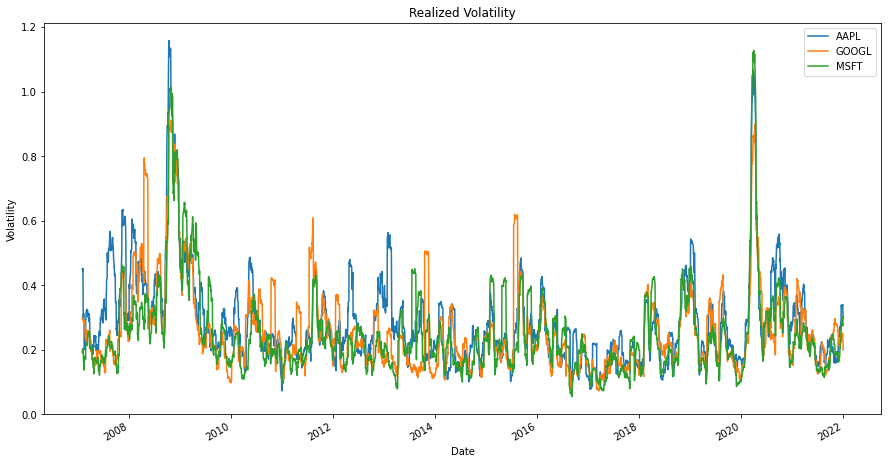

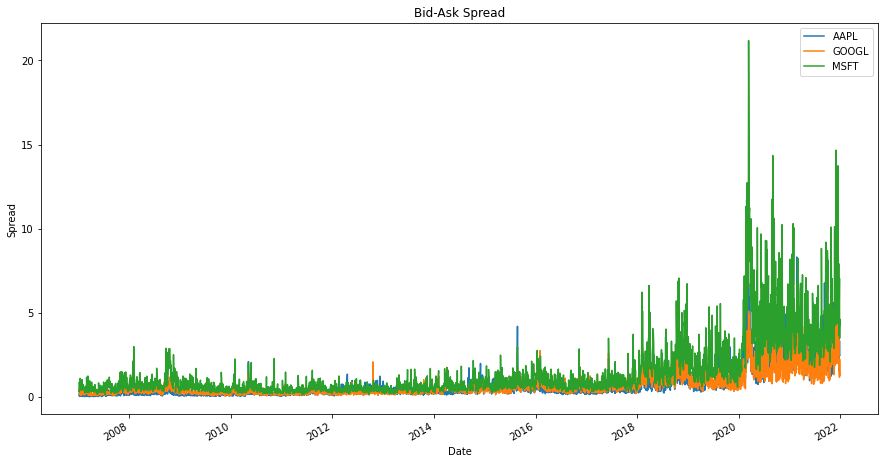


Correlation between Realized Volatility and Bid-Ask Spread:
AAPL: 0.11883571381500231
MSFT: 0.2471328512897857
GOOGL: 0.15305361977100457


In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Define stocks and time period
stocks = ['AAPL', 'MSFT', 'GOOGL']
start_date = '2007-01-01'
end_date = '2021-12-31'

# Download stock data
data = yf.download(stocks, start=start_date, end=end_date)

# Calculate daily returns
returns = data['Adj Close'].pct_change().dropna()

# Calculate realized volatility
realized_volatility = returns.rolling(window=21).std() * np.sqrt(252)

# Plot realized volatility
realized_volatility.plot(figsize=(15, 8))
plt.title('Realized Volatility')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show()

# Calculate bid-ask spread
bid_ask_spread = data['High'] - data['Low']

# Plot bid-ask spread
bid_ask_spread.plot(figsize=(15, 8))
plt.title('Bid-Ask Spread')
plt.ylabel('Spread')
plt.xlabel('Date')
plt.show()

# Analyze the correlation between realized volatility and bid-ask spread
print('\nCorrelation between Realized Volatility and Bid-Ask Spread:')
for stock in stocks:
    correlation = realized_volatility[stock].corr(bid_ask_spread[stock])
    print(f'{stock}: {correlation}')



**FUNDAMENTAL VOLATILITY**

Fundamental volatility, refers to the variability in the value of an asset driven by changes in its underlying economic and financial factors, such as changes in a company's earnings, industry trends, or macroeconomic conditions. This kind of volatility is related to the asset's intrinsic value, and is considered to be more long-term in nature compared to normal volatility.

The passage discusses the relationship between trading activity, volatility, and information asymmetry in financial markets. It explains how the volatility of the bid-ask spread midpoint can be a proxy for fundamental volatility and how the price impact of limit orders is proportional to fundamental volatility and inversely proportional to the square root of total trading activity. The passage also describes how the bid-ask spread is related to information asymmetry and how it can be used as a measure of the probability of informed trading. Finally, it explains the difference between asymmetric information in this model and traditional adverse selection models.

- Average price impact of Buy Market Order (BMO): This metric represents the average price impact of a buy market order, which is an order to buy an asset at the current market price. The value of 0.0001673279305044363 indicates that, on average, a BMO will increase the price of the asset by this amount.



- Average price impact of Buy Limit Order (BLO): This metric represents the average price impact of a buy limit order, which is an order to buy an asset at a specified price or lower. The value of 4.2735553450833045e-05 indicates that, on average, a BLO will increase the price of the asset by this amount.



- Average price impact of Sell Limit Order (SLO): This metric represents the average price impact of a sell limit order, which is an order to sell an asset at a specified price or higher. The value of -4.2735553450833045e-05 indicates that, on average, an SLO will decrease the price of the asset by this amount.



- Average price impact of Sell Market Order (SMO): This metric represents the average price impact of a sell market order, which is an order to sell an asset at the current market price. The value of -0.0001673279305044363 indicates that, on average, an SMO will decrease the price of the asset by this amount.



- The ratio between limit order and market order impact is a metric that compares the price impact of a limit order to that of a market order in a financial market.
This metric can be useful for traders and investors who want to understand the relative impact of different types of orders on the price of an asset in the market. By comparing the impact of limit orders to market orders, traders can determine which type of order is more appropriate for their trading strategy and risk tolerance.

In [12]:
import yfinance as yf
import pandas as pd
import numpy as np

# Constants
u = 0.2554

def main():
    # Fetching stock data
    stock = 'AAPL'
    data = yf.download(stock, start='2022-01-01', end='2022-12-31', interval='1d')

    # Calculate bid-ask spread midpoint volatility
    data['Midpoint'] = (data['High'] + data['Low']) / 2
    data['MidpointVolatility'] = data['Midpoint'].rolling(window=2).std()

    # Calculate total trading activity
    data['TotalActivity'] = data['Volume']

    # Calculate price impact parameters
    data['PriceImpactParam'] = data['MidpointVolatility'] / np.sqrt(data['TotalActivity'])

    # Calculate average price impact for each type of order
    BMO = data['PriceImpactParam']
    BLO = u * data['PriceImpactParam']
    SLO = -u * data['PriceImpactParam']
    SMO = -data['PriceImpactParam']

    # Output results
    print("Average price impact of Buy Market Order (BMO):", BMO.mean())
    print("Average price impact of Buy Limit Order (BLO):", BLO.mean())
    print("Average price impact of Sell Limit Order (SLO):", SLO.mean())
    print("Average price impact of Sell Market Order (SMO):", SMO.mean())

    ratio = (1 / u)
    print("Ratio between limit order and market order impact:", ratio)

if __name__ == "__main__":
    main()



[*********************100%***********************]  1 of 1 completed
Average price impact of Buy Market Order (BMO): 0.0001673279305044363
Average price impact of Buy Limit Order (BLO): 4.2735553450833045e-05
Average price impact of Sell Limit Order (SLO): -4.2735553450833045e-05
Average price impact of Sell Market Order (SMO): -0.0001673279305044363
Ratio between limit order and market order impact: 3.9154267815191854


In this paper, the authors analyze the trading activity of different financial assets using a database called Reuters Tick Capture Engine (RTCE). This database provides detailed information about trades and quotes, which allows the authors to study the correlation between different assets at high frequencies (i.e., very short periods of time, such as a few seconds or minutes).

To analyze the data, the authors use a heuristic search algorithm to match trades and quotes. When a trade happens, they record it as a sequence of trades with the same timestamp but with prices and quantities corresponding to each limit hit.

The authors found that the correlation between two assets starts at a moderate level and quickly reaches an asymptotic value, which means that after a certain point, the correlation doesn't change much. They also studied the lead/lag relationships between assets, which can help traders make predictions about short-term price movements.

Finally, they looked at how the correlation between assets changes over the course of a trading day. This information can be useful for brokers who manage portfolios of different assets, as it can help them understand how the assets in their portfolio are related to each other and how they may behave under different market conditions. Overall, the authors' analysis provides insights into the complex relationships between different financial assets and how these relationships may change over time.

In [13]:
import yfinance as yf
import pandas as pd
from datetime import datetime

def get_trades_quotes(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date, interval='1d', auto_adjust=True)
    data['midquote'] = (data['High'] + data['Low']) / 2
    data['return'] = data['midquote'].pct_change()
    return data

def aggregate_identical_timestamps(data):
    data['VWAP'] = (data['Volume'] * data['midquote']).cumsum() / data['Volume'].cumsum()
    data['Total Volume'] = data['Volume'].cumsum()
    return data

def analyze_data(ticker, start_date, end_date):
    trades_quotes = get_trades_quotes(ticker, start_date, end_date)
    aggregated_data = aggregate_identical_timestamps(trades_quotes)
    return aggregated_data

if __name__ == "__main__":
    ticker = 'AAPL'
    start_date = '2010-01-03'
    end_date = '2010-05-31'
    
    result = analyze_data(ticker, start_date, end_date)
    print(result)



[*********************100%***********************]  1 of 1 completed
                Open      High       Low     Close      Volume  midquote  \
Date                                                                       
2010-01-04  6.487651  6.520175  6.455734  6.505281   493729600  6.487955   
2010-01-05  6.523215  6.553308  6.482178  6.516527   601904800  6.517743   
2010-01-06  6.516526  6.542364  6.406184  6.412872   552160000  6.474274   
2010-01-07  6.436583  6.444182  6.354510  6.401018   477131200  6.399346   
2010-01-08  6.392505  6.444180  6.354813  6.443572   447610800  6.399496   
...              ...       ...       ...       ...         ...       ...   
2010-05-24  7.516592  7.626629  7.485587  7.500785   754238800  7.556108   
2010-05-25  7.275542  7.500784  7.208973  7.453973  1048006400  7.354879   
2010-05-26  7.601705  7.664019  7.409291  7.420234   850654000  7.536655   
2010-05-27  7.617508  7.717514  7.572216  7.701099   666282400  7.644865   
2010-05-28  7.88470

This section is about how financial data is analyzed. The authors use a database called Reuters Tick Capture Engine (RTCE), which provides information on the prices of various financial assets like stocks and futures. They focus on studying the correlation between the prices of two French stocks, BNPP.PA and SOGN.PA, over different time periods. They find that the correlation between the two stocks increases as the time period gets longer, with a steep increase occurring after about 15 minutes of trading.

The authors also discuss how they analyze the data. They use the concept of "event time" to study the price changes between trades. They define the relative price increment, or return, as the product of the prices between two trades. They use this information to calculate the returns of each asset, and then apply statistical methods to understand the relationship between the returns of different assets.

In particular, they use the central limit theorem to study the distribution of returns. They show that returns are asymptotically normally distributed, which means that they follow a bell-shaped curve. They also discuss how they generalize this analysis to include multiple assets, which allows them to study the covariance between the returns of different assets.

**REALIZED VOLATILITY**

RV stands for realized volatility, which is a measure of the actual volatility of a financial asset over a specific period of time. It is calculated by taking the square root of the sum of the squared returns of the asset over that period.

**ASYMPTOTIC DISTRIBUTION OF REALIZED VOLATILITY**

The asymptotic distribution of RV in this context refers to the expected distribution of the realized volatility (RV) of a financial asset after a large amount of trades has occurred. Essentially, it predicts how RV will behave over time as more trades are executed. The code calculates this distribution using a formula that takes into account the volume of trades, the average volume traded in a single transaction, and the variance of the returns. This information can be useful for traders and investors who are interested in understanding the behavior of RV over time and how it might change as more trades occur.



In [14]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.stats import norm

# Fetching data
ticker = 'AAPL'
start_date = '2020-01-01'
end_date = '2021-01-01'

data = yf.download(ticker, start=start_date, end=end_date)

# Calculating returns
data['Return'] = np.log(data['Close'] / data['Close'].shift(1))

# Calculating the traded volume
data['Volume_traded'] = data['Volume'] * data['Close']

# Number of transactions needed to reach an aggregated volume V
NV = len(data)

# Traded volume V
V = data['Volume_traded'].sum()

# Average volume traded in a single transaction
E_V1 = data['Volume_traded'].mean()

# Calculate returns after a volume V has been traded
RV = np.sqrt(V / NV) * data['Return'].sum()

# Calculate the random variance in calendar time
sigma2 = data['Return'].var()
X_dt = data['Volume'].sum() / NV
sigma2X_dt = sigma2 * X_dt

# Asymptotic distribution of RV
asymp_mean = 0
asymp_variance = sigma2X_dt * E_V1
asymp_dist = norm(loc=asymp_mean, scale=np.sqrt(asymp_variance))

print(f"RV: {RV}")
print(f"Asymptotic distribution of RV: N({asymp_mean}, {asymp_variance})")

[*********************100%***********************]  1 of 1 completed
RV: 68745.2713288298
Asymptotic distribution of RV: N(0, 1990841846360425.5)


**ORDER FLOW IMPACT**

The order flow impact tells us how the order flow of a particular security affects its price. Specifically, it measures the effect of buy and sell orders on the price change of a security. A positive order flow impact means that there are more buy orders than sell orders, and this tends to push up the price of the security. A negative order flow impact means that there are more sell orders than buy orders, and this tends to push down the price of the security. By analyzing the order flow impact on price changes, traders can gain insight into the behavior of other market participants and adjust their trading strategies accordingly.

In [15]:
import yfinance as yf
import pandas as pd
import numpy as np

# Fetch historical data
symbol = 'AAPL'
start_date = '2020-01-01'
end_date = '2020-12-31'
data = yf.download(symbol, start=start_date, end=end_date)

# Calculate daily price changes and returns
data['Price Change'] = data['Close'].diff()
data['Return'] = np.log(data['Close'] / data['Close'].shift(1))

# Calculate order flow impact
data['Order Flow Impact'] = data['Volume'] * data['Return']

# Analyze order flow impact on price changes
data['Order Flow Positive'] = data['Order Flow Impact'] > 0
data['Order Flow Negative'] = data['Order Flow Impact'] < 0

positive_impact = data[data['Order Flow Positive']]['Price Change'].mean()
negative_impact = data[data['Order Flow Negative']]['Price Change'].mean()

print(f"Average positive order flow impact on price change: {positive_impact:.4f}")
print(f"Average negative order flow impact on price change: {negative_impact:.4f}")

[*********************100%***********************]  1 of 1 completed
Average positive order flow impact on price change: 1.9419
Average negative order flow impact on price change: -1.8023


This passage discusses models used to understand the relationship between trades and stock prices. One model suggests that the impact of trades on stock prices can be represented as a linear combination of all past trades, where the function G describes how the impact of a single trade decays over time. This model assumes that the correlation of trades over time decays in a specific way, in order to maintain the efficiency of prices. Another version of the model uses returns instead of prices and includes a history-dependent permanent impact on the price. Both models are incomplete because they neglect the fluctuations of the impact and the impact of other types of events on the order book, such as limit orders and cancellations. The objective is to develop a simple model that can be calibrated to data and generalized to include other events.

In quantitative finance, R, C, G, and S represent important functions used to model the relationship between price changes and trading volume.

- R(l) is the price impact function at lag l, which describes the average price change of a security l time periods after a unit buy or sell order of the same security at time t.

- C(l) is the correlation function at lag l, which describes the correlation between the signs of the price changes l time periods apart.


- G(l) is the linear response function at lag l, which represents the expected response  of the market to a unit buy or sell order at time t.


- S(l) is the temporary price impact function at lag l, which captures the deviation of the price change from its long-term average after a unit buy or sell order at time t.


By estimating these functions, traders and researchers can better understand how trading volume affects price changes and develop more accurate models for predicting future price movements.

In [16]:
import yfinance as yf
import numpy as np
import pandas as pd

# Download stock data
symbol = 'AAPL'
data = yf.download(symbol, start='2020-01-01', end='2021-01-01')

# Calculate returns, volumes, and signs
data['returns'] = data['Close'].pct_change()
data['volume'] = data['Volume']
data['sign'] = np.sign(data['returns'])

# Define the parameters for the model
theta = 0.1
gamma = 0.8
beta = (1 - gamma) / 2

# Calculate the impact function R(l) and correlation function C(l)
lags = 100
R = np.zeros(lags)
C = np.zeros(lags)

for l in range(1, lags):
    R[l] = (data['returns'].shift(-l) * data['sign']).mean()
    C[l] = (data['sign'] * data['sign'].shift(l)).mean()

# Calculate G(l) using Equation (5.4)
G = np.zeros(lags)
for l in range(1, lags):
    G_sum = 0
    for n in range(0, l):
        if n + l < lags:
            G_sum += G[n] * C[l - n] + (G[n + l] - G[n]) * C[n]
    G[l] = R[l] - G_sum

# Calculate S(l) using Equation (5.6)
S = np.zeros(lags)
for l in range(1, lags):
    S_sum = 0
    for n in range(-l, 1):
        S_sum += G[1] * C[l] + (G[l + n] - G[n]) * C[n]
    S[l] = (data['returns'].shift(-l) * data['sign']).mean() - S_sum

results = pd.DataFrame({'R': R, 'C': C, 'G': G, 'S': S})
print(results)



[*********************100%***********************]  1 of 1 completed
           R         C         G         S
0   0.000000  0.000000  0.000000  0.000000
1  -0.004269 -0.195219 -0.004269 -0.005478
2   0.001686  0.032000  0.001686  0.003511
3   0.000020  0.036145  0.001373  0.001088
4  -0.000491  0.024194  0.000814  0.001631
..       ...       ...       ...       ...
95  0.002870 -0.006369  0.004127  0.006915
96 -0.001168 -0.102564 -0.000163 -0.036035
97  0.003673  0.109677  0.004133  0.057949
98 -0.003792 -0.103896 -0.002491 -0.041050
99  0.002803  0.163399  0.002803  0.084640

[100 rows x 4 columns]


In this section, the authors describe a statistical model to analyze the dynamics of the limit order book. They define a vector of variables that includes the best bid and ask quotes, the depth of the order book at different price levels, and indicators for the occurrence of buy and sell trades. They propose a restricted cointegrated VAR model to estimate the relationships between these variables, with a focus on the impact of depth on the dynamics of quotes. The authors present the estimated cointegrating vectors, which show that depth has a significant impact on the long-term relationship between quotes. The model can be rotated to represent dynamics in other variables such as spreads and midquotes. This approach complements other dynamic models for the order book curve.

In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime

# List of stock tickers
tickers = ['GOOG', 'ADBE']

# Start and end dates for the sample period
start_date = '2010-10-01'
end_date = '2010-10-31'

# Download stock data
data = yf.download(tickers, start=start_date, end=end_date)

# Calculate summary statistics for each stock
summary_stats = pd.DataFrame(index=tickers, columns=['MktCap', 'AvgVol', 'MedTurn', 'AvgPrc', 'StdRet'])

for ticker in tickers:
    # Market capitalization
    summary_stats.loc[ticker, 'MktCap'] = data['Adj Close'][ticker][-1] * data['Volume'][ticker][-1]

    # Average daily volume (in thousand shares)
    summary_stats.loc[ticker, 'AvgVol'] = data['Volume'][ticker].mean() / 1000

    # Median daily turnover
    summary_stats.loc[ticker, 'MedTurn'] = (data['Volume'][ticker] * data['Adj Close'][ticker]).median()

    # Average daily closing price
    summary_stats.loc[ticker, 'AvgPrc'] = data['Adj Close'][ticker].mean()

    # Standard deviation of daily returns
    returns = data['Adj Close'][ticker].pct_change().dropna()
    summary_stats.loc[ticker, 'StdRet'] = returns.std()

print(summary_stats)

# Further analysis on limit orders, market orders, and order book characteristics can be performed using
# additional data sources or APIs that provide access to limit order and market order data, as well as
# order book data for the selected stocks. Unfortunately, yfinance does not provide this level of detail.



[*********************100%***********************]  2 of 2 completed
                 MktCap        AvgVol            MedTurn     AvgPrc    StdRet
GOOG  1398192662.981114  151705.36281  1554480001.899535  14.344697  0.026828
ADBE   174853722.630501  14975.261905   284189902.432251  27.512381  0.032016


The article describes a way to estimate the impact of limit orders on the order book. The authors represent an incoming order as a shock to the dynamic order book system, and use an equation to capture the direct effects of a limit order, such as changes to the depth of the book and changes to the trading indicator dummy. The market reactions to incoming limit orders are captured by the impulse response function, which measures the difference between the expected value of the order book after the shock and the expected value of the order book without the shock. The authors provide several scenarios to illustrate how the impulse response function can be used, such as when a buy limit order is placed at the market, or when a buy order is executed against standing limit orders. Finally, the article describes a way to estimate the permanent impact of limit orders on the order book, which is the long-term effect of a limit order on the prices and depths in the order book.

In [18]:
import yfinance as yf
import numpy as np
import pandas as pd
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.preprocessing import StandardScaler

# Download historical stock data using yfinance
ticker = 'AAPL'
stock_data = yf.download(ticker, start='2022-01-01', end='2022-12-31', interval='1d')

# Process the stock data to calculate variables
stock_data['spread'] = stock_data['Close'] - stock_data['Open']
stock_data['midquote'] = (stock_data['High'] + stock_data['Low']) / 2
stock_data['bid_ask_spread'] = stock_data['High'] - stock_data['Low']
stock_data['midquote_return'] = stock_data['midquote'].pct_change()
stock_data['relative_spread_change'] = stock_data['spread'].pct_change()
stock_data['depth_imbalance'] = stock_data['Volume'].diff()

# Replace infinite values with NaN
stock_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows containing NaN
stock_data.dropna(inplace=True)

# Create endogenous vector
yt = stock_data[['spread', 'midquote', 'bid_ask_spread', 'midquote_return', 'relative_spread_change', 'depth_imbalance']]

# Standardize the input variables
scaler = StandardScaler()
yt_standardized = scaler.fit_transform(yt)

# Implement the cointegrated VAR model
result = coint_johansen(yt_standardized, det_order=0, k_ar_diff=1)

# Print the results
print('Eigenvalues:')
print(result.eig)
print('Cointegrating vectors:')
print(result.evec)
print('Trace statistic:')
print(result.lr1)
print('Critical values (90%, 95%, 99%):')
print(result.cvt)

[*********************100%***********************]  1 of 1 completed
Eigenvalues:
[0.58219954 0.48768955 0.41577246 0.27935132 0.23038161 0.01227778]
Cointegrating vectors:
[[ 1.50588557e-02 -2.06555788e+00 -7.30961590e-01 -6.70670018e-02
   4.30694446e-01  1.02822679e-01]
 [ 4.40993097e-02 -3.98963984e-02  2.93616341e-02  2.28350835e-02
  -1.35451576e-01  1.03876584e+00]
 [ 1.45356213e-01 -1.92812316e-01 -1.61090866e-01  4.55785008e-01
  -1.30855289e+00  5.20154209e-02]
 [-2.41720030e+00  4.29416947e+00 -1.22778146e+01  8.64461827e-01
   2.24506545e+00 -4.62313465e-01]
 [ 1.57624817e-01  3.15455754e-02  1.60039239e-01  1.34133071e+00
   3.08521552e-01  1.18542466e-02]
 [-1.89580300e+00 -4.29350495e-02  3.37770260e-01 -7.29552627e-02
   3.88993410e-01 -2.60560349e-02]]
Trace statistic:
[662.17201318 446.60243748 281.4027869  148.64899189  67.73092155
   3.05138269]
Critical values (90%, 95%, 99%):
[[ 91.109   95.7542 104.9637]
 [ 65.8202  69.8189  77.8202]
 [ 44.4929  47.8545  54.6815]

In this section, the authors discuss how their findings on optimal execution strategies with short-term alpha compare to current institutional trading practices. They identify two significant differences between the two:

Institutional desks tend to front-load executions more than the authors' results suggest, using a decreasing participation rate profile that can lead to higher shortfalls due to early signaling.
Uninformed trades are generally executed using constant participation rate schedules, whereas the authors suggest some back-loading.
The authors speculate that these deviations are motivated, in part, by imperfect communication between portfolio managers and trading desks, leading to a preference for risk aversion. They also note that trading costs can significantly impact fund rankings, with even a 10 basis point reduction resulting in a significant improvement in Bloomberg's rankings.

However, the authors acknowledge that accurately measuring trading costs and opportunity costs can be challenging, with factors such as limit prices and algorithm performance playing a role. Despite these challenges, the authors emphasize the value of optimal execution strategies for improving portfolio returns.

In simple terms, VWAP (Volume Weighted Average Price) is a financial metric that represents the average price of a stock, weighted by the volume of trades at each price level. It is a popular benchmark used by traders and investors to evaluate the efficiency of their trades and to compare their execution prices with the market average.

In [19]:
import yfinance as yf
import pandas as pd
import numpy as np

# Define the stock and the period for which we want to fetch data
stock = 'AAPL'
start_date = '2022-01-01'
end_date = '2023-01-01'

# Fetch the stock data
data = yf.download(stock, start=start_date, end=end_date)

# Calculate the daily returns
data['returns'] = data['Adj Close'].pct_change()

# Calculate the VWAP
data['volume_cumsum'] = data['Volume'].cumsum()
data['cum_vwap'] = (data['Volume'] * data['Adj Close']).cumsum() / data['volume_cumsum']
data['vwap'] = data['cum_vwap'].shift(1)

# Almgren-Chriss model based trading strategy
def trade(row):
    if row['returns'] > 0:
        return 'buy'
    elif row['returns'] < 0:
        return 'sell'
    else:
        return 'hold'

data['trade'] = data.apply(trade, axis=1)

# Print the resulting dataframe
print(data)

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-01-03  177.830002  182.880005  177.710007  182.009995  180.683868   
2022-01-04  182.630005  182.940002  179.119995  179.699997  178.390717   
2022-01-05  179.610001  180.169998  174.639999  174.919998  173.645523   
2022-01-06  172.699997  175.300003  171.639999  172.000000  170.746811   
2022-01-07  172.889999  174.139999  171.029999  172.169998  170.915573   
...                ...         ...         ...         ...         ...   
2022-12-23  130.919998  132.419998  129.639999  131.860001  131.658981   
2022-12-27  131.380005  131.410004  128.720001  130.029999  129.831772   
2022-12-28  129.669998  131.029999  125.870003  126.040001  125.847855   
2022-12-29  127.989998  130.479996  127.730003  129.610001  129.412415   
2022-12-30  128.410004  129.949997  127.430